Validation Accuracy: 0.9375
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

Test Accuracy: 0.81640625
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       124
           1       0.76      0.95      0.84       132

    accuracy                           0.82       256
   macro avg       0.84      0.81      0.81       256
weighted avg       0.84      0.82      0.81       256



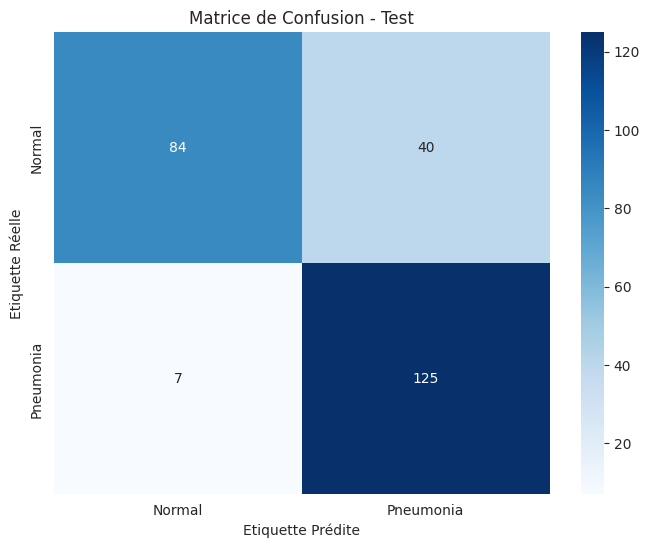

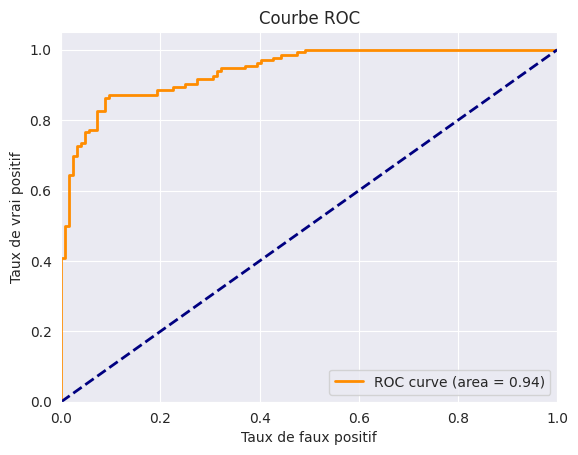

In [2]:
import os
import numpy as np
import joblib
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def load_images_and_labels(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    for label, sub_dir in enumerate(['NORMAL', 'PNEUMONIA']):
        path = os.path.join(base_dir, sub_dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(img_size)  # Resize the image
            img_array = np.array(img)
            images.append(img_array.flatten())  # Flatten the image to a 1D array
            labels.append(label)
    return np.array(images), np.array(labels)

img_size = (128, 128)  
X_train, y_train = load_images_and_labels('./img/train', img_size)
X_val, y_val = load_images_and_labels('./img/val', img_size)
X_test, y_test = load_images_and_labels('./img/test', img_size)

model_path = './model/model.pkl'
scaler_path = './model/scaler.pkl'

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000) 
model.fit(X_train_scaled, y_train)

joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)

# Validation
y_val_pred = model.predict(X_val_scaled)
print(
    "Validation Accuracy:", 
    accuracy_score(y_val, y_val_pred)
)
print(
    classification_report(
        y_val, 
        y_val_pred
    )
)

# Test
y_test_pred = model.predict(X_test_scaled)
print(
    "Test Accuracy:", 
    accuracy_score(
        y_test, 
        y_test_pred
    )
)
print(
    classification_report(
        y_test, 
        y_test_pred
    )
)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=[
        'Normal', 
        'Pneumonia'
    ], 
    yticklabels=[
        'Normal', 
        'Pneumonia'
    ]
)
plt.title('Matrice de Confusion - Test')
plt.ylabel('Etiquette Réelle')
plt.xlabel('Etiquette Prédite')
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binariser les étiquettes en format one-vs-all
y_test_binarized = label_binarize(y_test, classes=[0, 1])
y_score = model.decision_function(X_test_scaled)

# Calculer les taux de faux positifs et vrais positifs
fpr, tpr, _ = roc_curve(y_test_binarized, y_score)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(
    fpr, 
    tpr, 
    color='darkorange', 
    lw=2, 
    label='ROC curve (area = %0.2f)' % roc_auc
)
plt.plot(
    [0, 1], 
    [0, 1], 
    color='navy', 
    lw=2, 
    linestyle='--'
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positif')
plt.ylabel('Taux de vrai positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()